In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sci
from scipy import constants
from scipy.constants import physical_constants as pc
from scipy.integrate import quad
import sigfig as sf

/home/mbergamo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.style.use(['science', 'notebook', 'grid'])
tex_fonts = {
    "text.usetex": True,# Use LaTeX to write all text
    "font.family": "serif",
    # # Use 9pt font in plots, to match 9pt caption fontsize in RevTeX
    # "axes.labelsize": 9,
    # "font.size": 9,
    # # Make the legend/label fonts a little smaller
    # "legend.fontsize": 8,
    # "figure.titlesize": 8,
    # "xtick.labelsize": 8,
    # "ytick.labelsize": 8,
    "lines.linewidth": 1,
    "xtick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.major.width": 0.5,
    "ytick.minor.width": 0.5,
    "axes.linewidth": 0.5
}
plt.rcParams.update(tex_fonts)

In [3]:
m = pc['neutron mass energy equivalent in MeV'][0] # 939.5654205 ± 0.0000005 MeV
c = pc['speed of light in vacuum'][0]              # 299792458 m/s 

def v(T):
    return np.sqrt(2*T/m)

def v_rel(T):
    return np.sqrt(1 - 1/(1 + T/m)**2) #*c

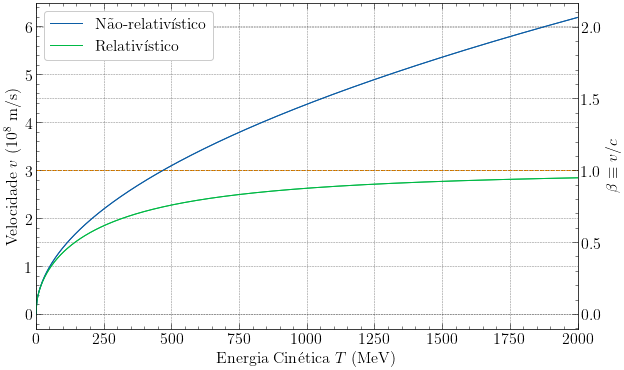

In [4]:
x = np.linspace(0, 2000, 500)
y1 = v(x)
y2 = v_rel(x)
z0 = c*np.ones(len(x))

fig, ax1 = plt.subplots(figsize=(1.618*6,6))

ax1.set_xlabel('Energia Cinética $T$ (MeV)')
ax1.set_ylabel(r'Velocidade $v$ ($10^{8}$ m/s)')
ax1.plot(x,y1*c/1e8, label = 'Não-relativístico')
ax1.plot(x,y2*c/1e8, label = 'Relativístico')
ax1.plot(x,z0/1e8,'--')
ax1.set_xlim(0, 2000)
# ax1.set_ylim(0, 6e8)


ax2 = ax1.twinx()
ax2.set_xlabel('Kinetic Energy T (MeV)')
ax2.set_ylabel(r'$\beta \equiv v/c$')
ax2.plot(x,y1, label = 'Não-relativístico')
ax2.plot(x,y2, label = 'Relativístico')
ax2.legend(framealpha=1)
fig.savefig('veloci1.pdf', dpi=600)

In [23]:
df = pd.read_csv('Displacement_Energy.csv', comment='#', header=None)
print(df)

      0             1         2
0     5  1.220720e-24  0.009350
1    30  2.003640e-25  0.012488
2    50  1.199550e-25  0.012276
3   100  5.985340e-26  0.012051
4     5  1.208320e-22  0.008001
5    30  2.013860e-23  0.008001
6    50  1.208320e-23  0.008001
7   100  6.041580e-24  0.008001
8     5  1.829550e-21  0.007891
9    30  2.732720e-22  0.007928
10   50  1.557850e-22  0.007800
11  100  7.237070e-23  0.007899
12    5  3.724880e-21  0.004102
13   30  6.210310e-22  0.003821
14   50  3.724870e-22  0.004102
15  100  1.862440e-22  0.004102
16    5  1.629680e-21  0.006986
17   30  2.604990e-22  0.006997
18   50  1.534210e-22  0.006975
19  100  7.476370e-23  0.006925


In [24]:
df_the = df.iloc[list(range(0,4))]
df_the.columns = ['E_th', 'DPA', 'rel_unc']
df_the['abs_unc'] = df_the['DPA']*df_the['rel_unc']
df_the

/tmp/ipykernel_130923/1165061708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_the['abs_unc'] = df_the['DPA']*df_the['rel_unc']


,E_th,DPA,rel_unc,abs_unc
0,5,1.220720e-24,0.009350,1.141424e-26
1,30,2.003640e-25,0.012488,2.502065e-27
2,50,1.199550e-25,0.012276,1.472544e-27
3,100,5.985340e-26,0.012051,7.212993e-28


No handles with labels found to put in legend.


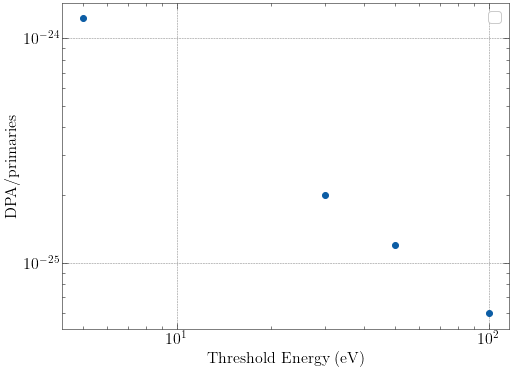

In [27]:
plt.errorbar(df_the['E_th'], df_the['DPA'], # Data
             df_the['abs_unc'],             # Uncertainty on y values
             fmt='o',
             ecolor = 'black', 
             capsize = 2
            )

plt.xlabel('Threshold Energy (eV)')
plt.ylabel('DPA/primaries')
plt.xscale('log')
plt.yscale('log')
plt.legend()